# CREATION D'UN INDICATEUR PTAL - Aire urbaine de Clermont-Ferrand




Données GTFS du SMTC, de la Région et de la SNCF


## Chargement librairies et fichiers

In [1]:
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np

Pour la formule de Haversine ci-dessous, lien d'aide :  https://www.movable-type.co.uk/scripts/latlong.html?from=49.1715000,-121.7493500&to=49.18258,-121.75441
et 
https://janakiev.com/blog/gps-points-distance-python/


In [2]:
######### fonctions ###################""

def l_haversine(coord1, coord2, R = 6371):
    """
    renvoie une liste de distances en kilometres
    a besoin de 2 listes de coordonnées (départ/arrivée) en entrée
    R : rayon de la Terre en km.
    """
     
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi       = np.radians(lat2 - lat1)
    dlambda    = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + \
        np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a))

## Chargement du fichier carreaux filosofi de l'INSEE

In [3]:
##### CHARGEMENT CARREAUX FILOSOFI
centroides_communes =  gpd.read_file(r'filo_emc2.geojson')
centroides_communes = centroides_communes.to_crs('epsg:4326')
centroides_communes['x'] = centroides_communes.centroid.x
centroides_communes['y'] = centroides_communes.centroid.y
#verif
# centroides_communes.head(2)#.plot(figsize=(15,15))

caro = centroides_communes.to_crs('epsg:4326')
# on met en cohérence les projections
caro.drop(columns = ['Id_carr1km', 'I_est_cr', 'Id_carr_n', 'Groupe', 'Depcom',
       'I_pauv', 'Id_car2010', 'Ind', 'Men', 'Men_pauv', 'Men_1ind',
       'Men_5ind', 'Men_prop', 'Men_fmp', 'Ind_snv', 'Men_surf', 'Men_coll',
       'Men_mais', 'Log_av45', 'Log_45_70', 'Log_70_90', 'Log_ap90', 'Log_inc',
       'Log_soc', 'Ind_0_3', 'Ind_4_5', 'Ind_6_10', 'Ind_11_17', 'Ind_18_24',
       'Ind_25_39', 'Ind_40_54', 'Ind_55_64', 'Ind_65_79', 'Ind_80p',
       'Ind_inc', 'I_est_1km'],inplace=True)
caro.head()

,IdINSPIRE,geometry,x,y
0,CRS3035RES200mN2533600E3738400,"MULTIPOLYGON (((2.52314 45.65165, 2.52340 45.6...",2.523912,45.652458
1,CRS3035RES200mN2528200E3733000,"MULTIPOLYGON (((2.46237 45.59848, 2.46238 45.5...",2.462358,45.598436
2,CRS3035RES200mN2562400E3743000,"MULTIPOLYGON (((2.54766 45.91560, 2.54760 45.9...",2.547613,45.915594
3,CRS3035RES200mN2558000E3737400,"MULTIPOLYGON (((2.47914 45.87061, 2.47893 45.8...",2.479106,45.869742
4,CRS3035RES200mN2564600E3743600,"MULTIPOLYGON (((2.55244 45.93502, 2.55248 45.9...",2.552190,45.934428


### Chargement du fichier de table horaires des réseaux de TC

In [4]:
table_TC = pd.read_csv(r'table_horaires.csv')

In [5]:
# conversion en table geolocalisée
geotable_TC = gpd.GeoDataFrame(table_TC, 
                               geometry=gpd.points_from_xy(table_TC.stop_lon_l, 
                                                           table_TC.stop_lat_l)).set_crs('epsg:2154')
geotable_TC.drop(columns=['stop_lon_l', 'stop_lat_l'], inplace=True)
geotable_TC.reset_index(drop=True, inplace=True)
geotable_TC.to_crs('epsg:4326', inplace=True)

In [6]:
# verification des types de transports
geotable_TC['type'].unique()

array(['CarRegion', 'TrainSNCF', 'CarSNCF', 'BHNS', 'tram', 'busUrbain'],
      dtype=object)

On découpe avec l'emprise, soit du test (fichier "decoup"), soit de la couche "caro" car les données de SNCF sont nationales

In [7]:
# geotable_clipped = gpd.clip(geotable_TC, decoup)
geotable_clipped = gpd.clip(geotable_TC, caro)
geotable_TC = geotable_clipped.copy()

On fait une vérification spatiale

<Axes: >

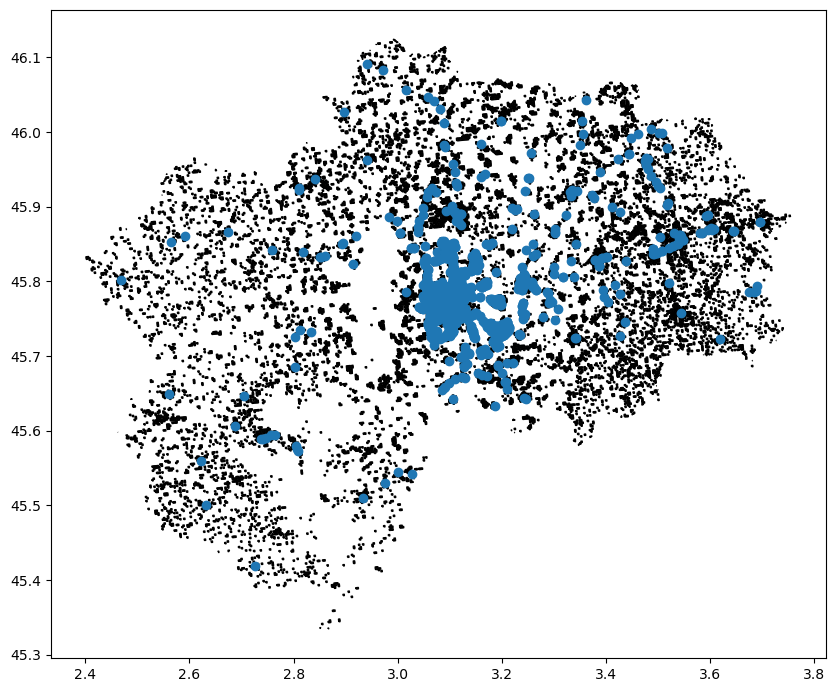

In [8]:
fig,ax= plt.subplots(figsize=(10,10)) # instacie un objet figure

caro.plot(ax=ax,color='white',edgecolor='black') # traçage des carreaux

geotable_TC.plot(ax=ax) # traçage des arrêts


### Calcul du PTAL

In [9]:

l_ptal = list()
# for xc, yc, u in zip(caro.x[160:161], caro.y[160:161], tqdm(caro.index)):
for xc, yc, u in zip(caro.x, caro.y, tqdm(caro.index)):


    l_dist = list()
    #     for g in geotable_TC.iloc:
    g = geotable_TC     
    xg = g.geometry.x
    yg = g.geometry.y

    #### formule de Haversine 
    dist_eucli = l_haversine((xc,yc), (xg,yg)) # résultats en kilomètres
    
    # on fait une copie du df existant contenant les arrets et leurs nombre de passages
    df = geotable_TC.copy()
    
    # on ajoute les distances aux arrêts depuis les centres des carreaux
    df['dist_'] = dist_eucli
    
    # on instancie un df temporaire qui contiendra pour les arrêts les plus proches les équivalents 
    t = pd.DataFrame()
    
    # On instancie une amplitude horaire de la periode observee 
    _AMPLI_ = 5

    # On boucle sur la jointure de liste {type, distance, facteur de fiabilité}
    for typ, dist, AWT in zip(['CarRegion', 'TrainSNCF', 'CarSNCF', 'BHNS', 'tram', 'busUrbain'],
#                          [300, 800, 300, 300, 600, 250]
                         [500, 1000, 500, 500, 1000, 500],
                         [2,0.75,2,2,1,2]
                         ):

        temp = df[(df['type']==typ) & (df['dist_'].values*1000<=(dist+100))] 

        if temp.empty:
            EDF=0
        else:
            # temps d'acces simplifié pour une vitesse de déplacement de 4km/h
            v = 4 #km/h
            v_m = 4 * 1000 / 60 # v en m/min

            d = temp.dist_ # distance en kilomètres
            d_m = d * 1000 # distance en mètres

            SAP = d_m / v_m # temps en minutes

            #frequence : nombre de passages / par amplitude horaire / 2 : donne temps d'attente moyen
            SWT = 0.5*(_AMPLI_/temp.trip_id )*60

            TAT = SAP + SWT + AWT

            # equivalent fréquence
            EDF = 0.5*(60/(TAT))
            temp['TAT'] = TAT
            temp['SAP'] = SAP
            temp['SWT'] = SWT
            temp['AWT'] = AWT

        temp['EDF'] = EDF


        # on concatène dans le DF temporaire
        t = pd.concat([t,temp])

    # on parcourt toutes les lignes du df temporaire pour calculer le PTAL
    ptal = 0
    for edf in t.EDF:
        coef = 0.5
        if edf == max(t.EDF.values):
            coef = 1
        ptal += coef * edf

    l_ptal.append(ptal)
        
caro['PTAL'] = l_ptal
caro.PTAL.fillna(0,inplace=True)

  0%|          | 0/20204 [00:00<?, ?it/s]

<Axes: >

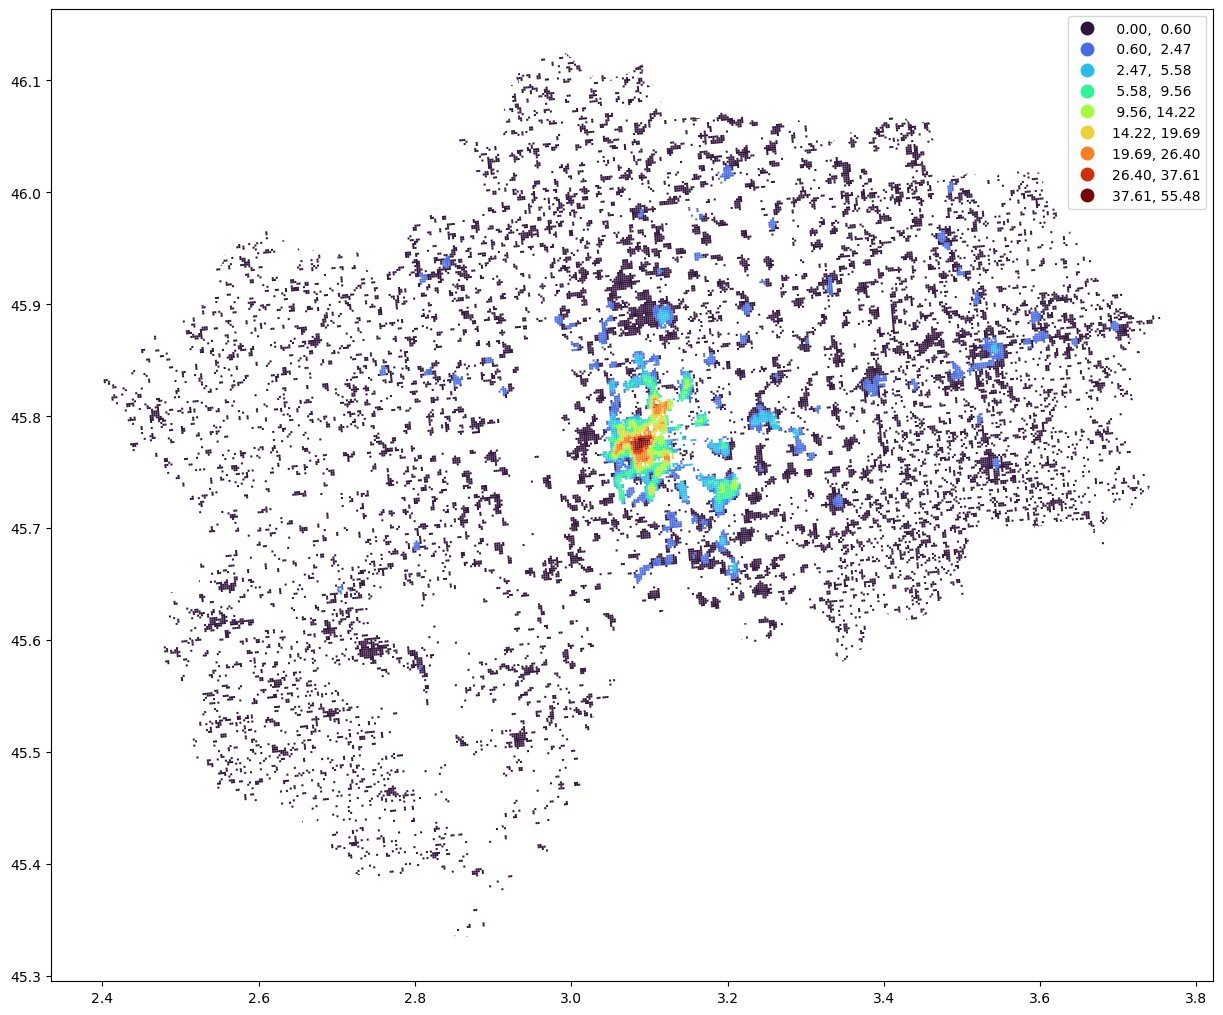

In [10]:
caro.plot(figsize = (15,15), column='PTAL', legend=True, scheme='natural_breaks', k=9, cmap='turbo')

### Export

In [88]:
caro.to_file(r'PTAL_Ok_test.geojson')

### Modélisation des fréquences par distances aux arrêts et services aux arrêts

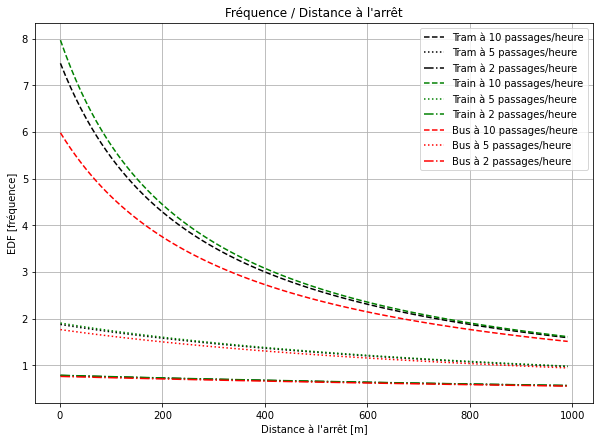

In [18]:
def d_edf(d_m, nbp = 10, amp = 5, AWT=0.75):
# temps d'acces simplifié pour une vitesse de déplacement de 4km/h
    v = 4 #km/h
    v_m = 4 * 1000 / 60 # v en m/min

    SAP = d_m / v_m # temps en minutes

    #frequence : nombre de passages / par amplitude horaire / 2 : donne temps d'attente moyen
    SWT = 0.5*(amp/nbp)*60
    TAT = SAP + SWT + AWT
    EDF = 0.5*(60/(TAT))

    return EDF

plt.subplots(figsize=(10,7))

p = 1000 # distance max

t0 = [d_edf(i, nbp = 50, AWT=1) for i in range(1,p,10)]
t1 = [d_edf(i,nbp = 10, AWT=1) for i in range(1,p,10)]
t2 = [d_edf(i, nbp = 4, AWT=1) for i in range(1,p,10)]

tn0 = [d_edf(i, nbp = 50, AWT=0.75) for i in range(1,p,10)]
tn1 = [d_edf(i,nbp = 10, AWT=0.75) for i in range(1,p,10)]
tn2 = [d_edf(i, nbp = 4, AWT=0.75) for i in range(1,p,10)]

bs0 = [d_edf(i, nbp = 50,AWT=2) for i in range(1,p,10)]
bs1 = [d_edf(i,nbp = 10, AWT=2) for i in range(1,p,10)]
bs2 = [d_edf(i, nbp = 4, AWT=2) for i in range(1,p,10)]

plt.plot(range(1,p,10), t0, 'k--', label='Tram à 10 passages/heure')
plt.plot(range(1,p,10), t1, 'k:',  label='Tram à 5 passages/heure')
plt.plot(range(1,p,10), t2, 'k-.', label='Tram à 2 passages/heure')

plt.plot(range(1,p,10), tn0 , 'g--', label='Train à 10 passages/heure')
plt.plot(range(1,p,10), tn1 , 'g:',  label='Train à 5 passages/heure')
plt.plot(range(1,p,10), tn2 , 'g-.', label='Train à 2 passages/heure')

plt.plot(range(1,p,10), bs0 , 'r--', label='Bus à 10 passages/heure')
plt.plot(range(1,p,10), bs1 , 'r:',  label='Bus à 5 passages/heure')
plt.plot(range(1,p,10), bs2 , 'r-.', label='Bus à 2 passages/heure')
plt.legend()
plt.xlabel("Distance à l'arrêt [m]")
plt.ylabel('EDF [fréquence]')
plt.title("Fréquence / Distance à l'arrêt")

# plt.savefig('edf.pdf')
plt.grid()
plt.show()


In [23]:
####### TESTS ....  ####

def d_edf_2(d_m, nbp = 10, amp = 5, AWT=0.75):
# temps d'acces simplifié pour une vitesse de déplacement de 4km/h
    v = 4 #km/h
    v_m = 4 * 1000 / 60 # v en m/min

    SAP = d_m / v_m # temps en minutes

    #frequence : nombre de passages / par amplitude horaire / 2 : donne temps d'attente moyen
    SWT = 0.5*(amp/nbp)/60
    TAT = SAP + SWT + AWT
    EDF = 0.5*(60/(TAT))

    return EDF, SWT

[d_edf_2(i, nbp = 50,AWT=2) for i in range(1,p,10)]


[(14.882182720132288, 0.0008333333333333334),
 (13.851481338976528, 0.0008333333333333334),
 (12.9543001079525, 0.0008333333333333334),
 (12.166272389320717, 0.0008333333333333334),
 (11.468620579802485, 0.0008333333333333334),
 (10.846640554383852, 0.0008333333333333334),
 (10.288653901114603, 0.0008333333333333334),
 (9.785267735797772, 0.0008333333333333334),
 (9.32884166882612, 0.0008333333333333334),
 (8.913097301312206, 0.0008333333333333334),
 (8.532827684285376, 0.0008333333333333334),
 (8.18367810866106, 0.0008333333333333334),
 (7.861978597947151, 0.0008333333333333334),
 (7.564614414793024, 0.0008333333333333334),
 (7.288924883579673, 0.0008333333333333334),
 (7.032623559288924, 0.0008333333333333334),
 (6.7937346669182865, 0.0008333333333333334),
 (6.5705420697207515, 0.0008333333333333334),
 (6.361547976674324, 0.0008333333333333334),
 (6.165439287549239, 0.0008333333333333334),
 (5.9810599767403225, 0.0008333333333333334),
 (5.807388288433618, 0.0008333333333333334),
 (5.